## Прогнозирование временных рядов с использованием рекуррентной нейронной сети RNN (LSTM-модель).

Time series prediction  using recurrent neural network RNN (LSTM model).

### Постановка задачи.

>Временной ряд – это последовательность значений, описывающих протекающий во времени процесс, измеренных в последовательные моменты времени, обычно через равные промежутки. Временной ряд отличается от простой выборки данных, так как при анализе учитывается взаимосвязь измерений со временем, а не только статистические характеристики выборки.

>Необходимость анализа и прогнозирования временных рядов часто возникает в задачах, связанных с ритейлом, финансами, web-аналитики, маркетинга и прочих. Интерес к данной теме автора работы связан с потребностями в анализе временных рядов при планировании продаж компании (по сути прогнозировании спроса) и соответственно планирования обеспечения товарами собственных складских помещений. 
  
>В качестве модели глубокого обучения будем использовать LSTM (Long Short-Term Memory). Эта модель является важным шагов в развитии рекуррентных нейронных сетей RNN и решает проблему затухания или наоборот, взрывного роста градиента в сети RNN. Другими словами, обычные RNN ячейки не могут “удержать в памяти” слишком длинные последовательности. Сеть LSTM способна изучать долгосрочные зависимости в данных, чем и объясняется ее использование при прогнозировании временных рядов.

>В работе решается задача предсказания цены на акцию компании Microsoft. Источником данных является датасет https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs.









In [ ]:
import numpy as np
import pandas as pd
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

#from pandas import datetime
import math, time
import itertools
import datetime

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from math import sqrt

import torch
import torch.nn as nn
from torch.autograd import Variable

### 1. Загрузка и исследование данных.

Датасет представляет собой архив csv-файлов, содержащих информацию о ценах и продажах акций различных компаний за определенный период времени. В качестве названия файлов используются тикеры акций компаний. 

Для исследования используется файл компании Microsot - "msft.us.txt". Хотя в названии указано расширение "txt", но это именно файл формата "csv". 

Считываем файл msft.us.txt в переменную df_msft:

In [ ]:
df_msft = pd.read_csv("msft.us.txt", parse_dates=["Date"])

Определим размер таблицы (количество строк, колонок):

In [ ]:
df_msft.shape

(7983, 7)

Посмотрим первые пять строк:

In [ ]:
df_msft.head(5)

,Date,Open,High,Low,Close,Volume,OpenInt
0,1986-03-13,0.06720,0.07533,0.06720,0.07533,1371330506,0
1,1986-03-14,0.07533,0.07533,0.07533,0.07533,409569463,0
2,1986-03-17,0.07533,0.07533,0.07533,0.07533,176995245,0
3,1986-03-18,0.07533,0.07533,0.07533,0.07533,90067008,0
4,1986-03-19,0.07533,0.07533,0.07533,0.07533,63655515,0


In [ ]:
# хвост данных
df_msft.tail()

,Date,Open,High,Low,Close,Volume,OpenInt
7978,2017-11-06,84.20,84.700,84.0825,84.47,19852151,0
7979,2017-11-07,84.77,84.900,83.9300,84.26,17927878,0
7980,2017-11-08,84.14,84.610,83.8300,84.56,18029584,0
7981,2017-11-09,84.11,84.270,82.9000,84.09,21175384,0
7982,2017-11-10,83.79,84.095,83.2300,83.87,19396301,0


Видим, что данные представлены за период от '1986-03-13' по '2017-11-10'.

In [ ]:
df_msft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7983 entries, 0 to 7982
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     7983 non-null   datetime64[ns]
 1   Open     7983 non-null   float64       
 2   High     7983 non-null   float64       
 3   Low      7983 non-null   float64       
 4   Close    7983 non-null   float64       
 5   Volume   7983 non-null   int64         
 6   OpenInt  7983 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 436.7 KB


Пропущенных значений нет.

In [ ]:
df_msft.describe()

,Open,High,Low,Close,Volume,OpenInt
count,7983.000000,7983.000000,7983.000000,7983.000000,7.983000e+03,7983.0
mean,18.977859,19.187219,18.773635,18.984698,7.945800e+07,0.0
std,16.416068,16.552604,16.277882,16.424012,5.214889e+07,0.0
min,0.067200,0.067200,0.067200,0.067200,0.000000e+00,0.0
25%,2.113300,2.155100,2.079700,2.113300,4.910587e+07,0.0
50%,20.462000,20.697000,20.251000,20.469000,7.059385e+07,0.0
75%,25.475000,25.754000,25.233000,25.483500,9.734927e+07,0.0
max,84.770000,86.200000,84.082500,84.560000,1.371331e+09,0.0


Явных аномалий нет.

Выведем список названий столбцов:

In [ ]:
df_msft.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'], dtype='object')



*   'Open', 'High', 'Low', 'Close' - цена акции при открытии торгового дня, максимальная цена, минимальная цена, цена при закрытии соответственно.
*   'Volume' - количество проданных акций.
*   'OpenInt' - этот параметр опускаем, как несущественный.









### 2. Подготовка данных.

**Для исследования возьмем последние 1996 строк, то есть за период с 2009-12-09 по 2017-11-10:**

**Предсказывать будем 'Close' - цену акции при закрытии торгового дня.**

Посмотрим на графике динамику изменения цены ('Close'):

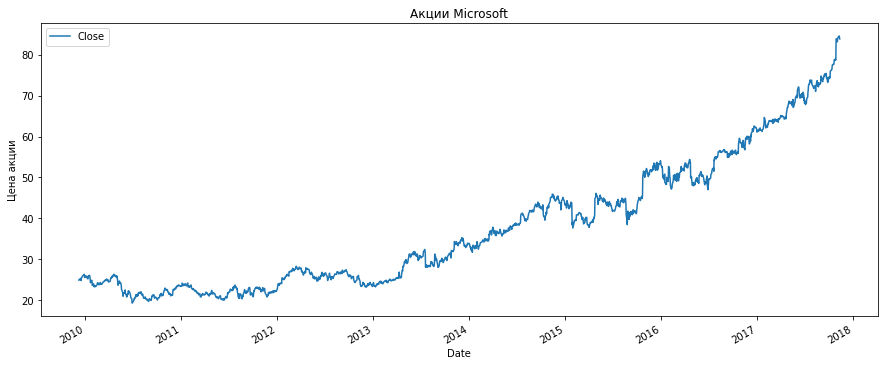

In [ ]:
df_msft[-1996:].plot(x="Date", y="Close", figsize=(15, 6))
plt.ylabel("Цена акции")
plt.title("Акции Microsoft")
plt.show()

Рассчитаем и визуализируем процентное изменение цены между текущим и предыдущим элементом:

In [ ]:
df_msft['pct'] = df_msft['Close'].pct_change()
df_msft

,Date,Open,High,Low,Close,Volume,OpenInt,pct
0,1986-03-13,0.06720,0.07533,0.06720,0.07533,1371330506,0,NaN
1,1986-03-14,0.07533,0.07533,0.07533,0.07533,409569463,0,0.000000
2,1986-03-17,0.07533,0.07533,0.07533,0.07533,176995245,0,0.000000
3,1986-03-18,0.07533,0.07533,0.07533,0.07533,90067008,0,0.000000
4,1986-03-19,0.07533,0.07533,0.07533,0.07533,63655515,0,0.000000
...,...,...,...,...,...,...,...,...
7978,2017-11-06,84.20000,84.70000,84.08250,84.47000,19852151,0,0.003922
7979,2017-11-07,84.77000,84.90000,83.93000,84.26000,17927878,0,-0.002486
7980,2017-11-08,84.14000,84.61000,83.83000,84.56000,18029584,0,0.003560
7981,2017-11-09,84.11000,84.27000,82.90000,84.09000,21175384,0,-0.005558


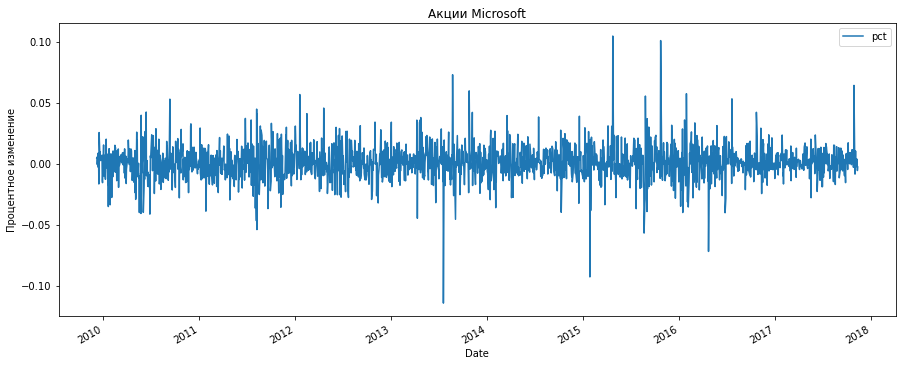

In [ ]:
df_msft[-1996:].plot(x="Date", y="pct", figsize=(15, 6))
plt.ylabel("Процентное изменение")
plt.title("Акции Microsoft")
plt.show()

Представим в виде отдельной таблицы:

In [ ]:
df = df_msft[-1996:]
#df

In [ ]:
df=df[['Close']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1996 entries, 5987 to 7982
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1996 non-null   float64
dtypes: float64(1)
memory usage: 15.7 KB


Разделим датафрейм на обучающую и тренировочную части:

In [ ]:
test_size = int(np.round(0.16*df.shape[0]))-3;
train_size = int(np.round(df.shape[0])) - test_size
print(train_size)
print(test_size)

1680
316


Выберем "тренировочное окно" равным 70, поскольку как обучающую, так и тестовую часть данных в дальнейшем разобьем на последовательности длиной 70, и плюс 71-значение будем считать "меткой". Таким образои, сведем задачу к задаче классификации.

In [ ]:
train_window = 70

In [ ]:
#df_train = df[:-test_size+train_window+1].loc[:]
df_train = df[:-test_size+1].loc[:]
#df_train

In [ ]:
#df_test = df[-test_size:].loc[:]
df_test = df[-test_size:]
#df_test

Независимо нормализуем  данные обучающего и тестового наборов:

In [ ]:
df_train=df_train.fillna(method='ffill')
df_test=df_test.fillna(method='ffill')

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df_train['Close'] = scaler.fit_transform(df_train['Close'].values.reshape(-1,1))
df_test['Close'] = scaler.fit_transform(df_test['Close'].values.reshape(-1,1))

Создаем последовательности:

In [ ]:
# создаем последовательности для обучающего набора
data_temp = df_train.values
data = []

for index in range(len(data_temp) - train_window):
  data.append(data_temp[index: index + train_window+1])

data = np.array(data)
x_train = data[:,:-1,:]
y_train = data[:,-1,:]

In [ ]:
# создаем последовательности для тестового набора
data_temp = df_test.values
data = []
local_temp = train_window+1
for index in range(len(data_temp) - train_window):
#for index in range(len(data_temp) - local_temp):
  data.append(data_temp[index: index + train_window+1])

data = np.array(data)
x_test = data[:,:-1]
y_test = data[:,-1,:]
#len(x_test)

In [ ]:
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1611, 70, 1)
y_train.shape =  (1611, 1)
x_test.shape =  (246, 70, 1)
y_test.shape =  (246, 1)


В итоге получили 1611 последовательность обучающего набора и 246 последовательностей тестового набора.

Преобразуем в тензоры Torch:

In [ ]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [ ]:
y_train.size(),x_train.size()

(torch.Size([1611, 1]), torch.Size([1611, 70, 1]))

### 3. Создание модели.

Опишем модель как как класс LSTM с входом и выходом равными = 1 и 32 -мя скрытыми слоями:

In [ ]:
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1

# Определяем модель как класс
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        out = self.fc(out[:, -1, :]) 
        
        return out

Определяем объект класса LSTM, функцию потерь и оптимизатор. Поскольку решаем задачу классификации, то будем использовать кросс-энтропию как функцию потерь. В качестве оптимизатора используем оптимизатор Аdam:

In [ ]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


### 4. Тренировка модели.

Укажем количество эпох и тренируем модель:

In [ ]:
num_epochs = 200
hist = np.zeros(num_epochs)

# Шаг тренировки
seq_dim = train_window

for t in range(num_epochs):
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.03738957270979881
Epoch  20 MSE:  0.024624882265925407
Epoch  30 MSE:  0.011697577312588692
Epoch  40 MSE:  0.006856844760477543
Epoch  50 MSE:  0.004149386193603277
Epoch  60 MSE:  0.0028860748279839754
Epoch  70 MSE:  0.002442588796839118
Epoch  80 MSE:  0.002155869733542204
Epoch  90 MSE:  0.00199541705660522
Epoch  100 MSE:  0.0019156262278556824
Epoch  110 MSE:  0.0018691789591684937
Epoch  120 MSE:  0.0018331775208935142
Epoch  130 MSE:  0.001802006270736456
Epoch  140 MSE:  0.001770813949406147
Epoch  150 MSE:  0.0017395152244716883
Epoch  160 MSE:  0.0017083699349313974
Epoch  170 MSE:  0.0016774212708696723
Epoch  180 MSE:  0.0016466999659314752
Epoch  190 MSE:  0.0016162731917575002


График функции потерь:

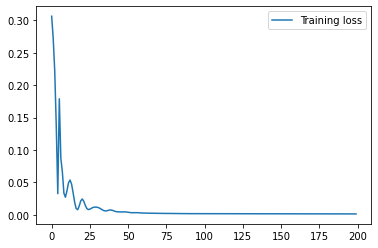

In [ ]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

### 5. Прогнозирование.

In [ ]:
# выполняем предсказание
y_test_pred = model(x_test)

# инвертируем результаты
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# считаем среднеквадратичную ошибку
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.59 RMSE
Test Score: 0.90 RMSE


Результаты предсказания цены акции представлены на графике:

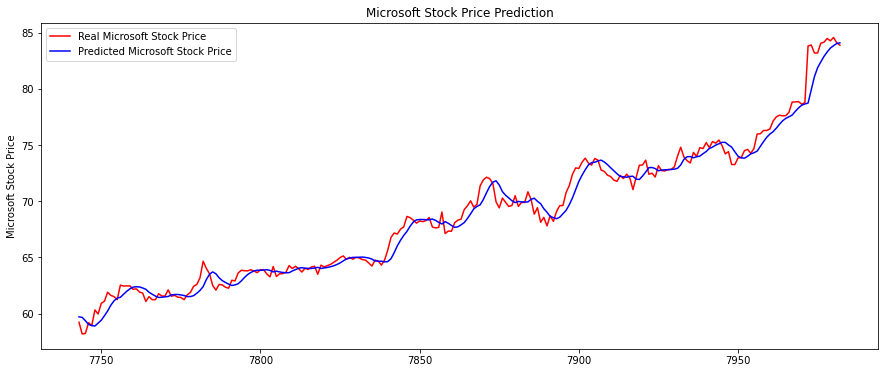

In [ ]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.plot(df[-240:].index, y_test[-240:], color = 'red', label = 'Real Microsoft Stock Price')
axes.plot(df[-240:].index, y_test_pred[-240:], color = 'blue', label = 'Predicted Microsoft Stock Price')
plt.title('Microsoft Stock Price Prediction')
plt.xlabel('')
plt.ylabel('Microsoft Stock Price')
plt.legend()
plt.savefig('Microsoft_pred_1.png')
plt.show()

### 6. Прогнозирование с предобработкой.

>  В предудущем разделе №5 в качестве baseline использовались "сырые" данные для построения прогноза. Это оправдано, например, в ситуацих нехватки времени. В данном же разделе выполним предобработку данных, а именно получим процентные изменения значений показателей по сравнению с предыдущим на временной шаг значением. И предсказывать будем не цену акции, а процентное изменение этой цены.

Выберем для исследования последние 1990 строк:

In [ ]:
df2 = df_msft[-1990:]
df2

,Date,Open,High,Low,Close,Volume,OpenInt,pct
5993,2009-12-17,25.115,25.123,24.7970,24.824,52046708,0,-0.016560
5994,2009-12-18,25.025,25.535,24.9890,25.458,112120128,0,0.025540
5995,2009-12-21,25.475,25.862,25.4670,25.595,47586782,0,0.005381
5996,2009-12-22,25.659,25.936,25.6110,25.846,43174657,0,0.009807
5997,2009-12-23,25.745,25.954,25.7370,25.929,33788511,0,0.003211
...,...,...,...,...,...,...,...,...
7978,2017-11-06,84.200,84.700,84.0825,84.470,19852151,0,0.003922
7979,2017-11-07,84.770,84.900,83.9300,84.260,17927878,0,-0.002486
7980,2017-11-08,84.140,84.610,83.8300,84.560,18029584,0,0.003560
7981,2017-11-09,84.110,84.270,82.9000,84.090,21175384,0,-0.005558


Создаем отдельную таблицу с единственной (помимо индекса) колонкой 'pct'. В этой колонке содержатся предварительно рассчитанне процентные изменения цены:

In [ ]:
df_pct=df2[['pct']]
df_pct

,pct
5993,-0.016560
5994,0.025540
5995,0.005381
5996,0.009807
5997,0.003211
...,...
7978,0.003922
7979,-0.002486
7980,0.003560
7981,-0.005558


Делим на обучающий и тестовый набор:

In [ ]:
df_pct_train = df_pct[:-test_size].loc[:]# обучающий набор
df_pct_train

,pct
5993,-0.016560
5994,0.025540
5995,0.005381
5996,0.009807
5997,0.003211
...,...
7662,0.009911
7663,0.001742
7664,0.002432
7665,-0.003098


In [ ]:
df_pct_test = df_pct[-test_size:].loc[:] # тестовый набор
df_pct_test

,pct
7667,-0.006186
7668,0.003112
7669,-0.005532
7670,0.002086
7671,0.000676
...,...
7978,0.003922
7979,-0.002486
7980,0.003560
7981,-0.005558


Выполняем стандартизацию данных с помощью StandartScaler:

In [ ]:
scaler = StandardScaler()
df_pct_train['pct'] = scaler.fit_transform(df_pct_train['pct'].values.reshape(-1, 1))
df_pct_test['pct'] = scaler.fit_transform(df_pct_test['pct'].values.reshape(-1, 1))

Создаем наборы последовательностей обучающего и тестового набора:

In [ ]:
data_temp = df_pct_train.values
data = []

for index in range(len(data_temp) - train_window):
  data.append(data_temp[index: index + train_window ])

data = np.array(data)
x_train_pct = data[:,:-1,:]
y_train_pct = data[:,-1,:]

In [ ]:
data_temp = df_pct_test.values
data = []
local_temp = train_window+1
#for index in range(len(data_temp) - local_temp):
for index in range(len(data_temp) - train_window):
  data.append(data_temp[index: index + train_window])

data = np.array(data)
x_test_pct = data[:,:-1]
y_test_pct = data[:,-1,:]
#len(x_test)

In [ ]:
print('x_train.shape = ',x_train_pct.shape)
print('y_train.shape = ',y_train_pct.shape)
print('x_test.shape = ',x_test_pct.shape)
print('y_test.shape = ',y_test_pct.shape)

x_train.shape =  (1604, 69, 1)
y_train.shape =  (1604, 1)
x_test.shape =  (246, 69, 1)
y_test.shape =  (246, 1)


В итоге получили 1604 последовательности обучающего набора и 246 последовательностей тестового набора.

Преобразуем в тензоры Torch:

In [ ]:
# in torch
x_train_pct = torch.from_numpy(x_train_pct).type(torch.Tensor)
x_test_pct = torch.from_numpy(x_test_pct).type(torch.Tensor)
y_train_pct = torch.from_numpy(y_train_pct).type(torch.Tensor)
y_test_pct = torch.from_numpy(y_test_pct).type(torch.Tensor)

Тренируем модель:

In [ ]:
num_epochs = 200
hist = np.zeros(num_epochs)

# Шаг тренировки
seq_dim = train_window

for t in range(num_epochs):
    
    # Forward pass
    y_train_pred_pct = model(x_train_pct)

    loss = loss_fn(y_train_pred_pct, y_train_pct)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.5557235479354858
Epoch  20 MSE:  0.4337475597858429
Epoch  30 MSE:  0.36563536524772644
Epoch  40 MSE:  0.3253336548805237
Epoch  50 MSE:  0.30331072211265564
Epoch  60 MSE:  0.2859139144420624
Epoch  70 MSE:  0.2710375189781189
Epoch  80 MSE:  0.27362188696861267
Epoch  90 MSE:  0.27210596203804016
Epoch  100 MSE:  0.2512187361717224
Epoch  110 MSE:  0.23983895778656006
Epoch  120 MSE:  0.23500443994998932
Epoch  130 MSE:  0.21877574920654297
Epoch  140 MSE:  0.21267548203468323
Epoch  150 MSE:  0.23988932371139526
Epoch  160 MSE:  0.20641328394412994
Epoch  170 MSE:  0.20319612324237823
Epoch  180 MSE:  0.19933609664440155
Epoch  190 MSE:  0.1929139792919159


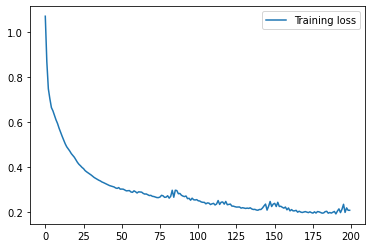

In [ ]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

Выполняем прогноз:

In [ ]:
# прогноз
y_test_pred_pct = model(x_test_pct)

In [ ]:
# инверсия
y_train_pred_pct = scaler.inverse_transform(y_train_pred_pct.detach().numpy())
y_train_pct = scaler.inverse_transform(y_train_pct.detach().numpy())
y_test_pred_pct = scaler.inverse_transform(y_test_pred_pct.detach().numpy())
y_test_pct = scaler.inverse_transform(y_test_pct.detach().numpy())

In [ ]:
# ошибка
trainScore = math.sqrt(mean_squared_error(y_train_pct[:,0], y_train_pred_pct[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test_pct[:,0], y_test_pred_pct[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.00 RMSE
Test Score: 0.02 RMSE


Представим результаты прогноза на графике:

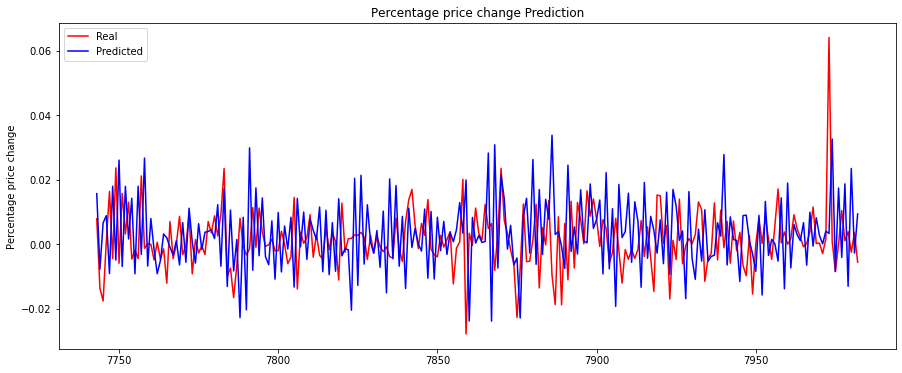

In [ ]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.plot(df2[-240:].index, y_test_pct[-240:], color = 'red', label = 'Real')
axes.plot(df2[-240:].index, y_test_pred_pct[-240:], color = 'blue', label = 'Predicted')
plt.title('Рercentage price change Prediction')
plt.xlabel('')
plt.ylabel('Рercentage price change')
plt.legend()
plt.savefig('Microsoft_pred_2.png')
plt.show()

##### Рассчитаем прогноз цены на основе предсказанных процентных изменений:

Посмотрим значение цены 'Close' 7667 строке датасета:

In [ ]:
rows = df_msft.iloc[-316:7668] 
print(rows)

           Date    Open   High     Low   Close    Volume  OpenInt       pct
7667 2016-08-12  56.314  56.47  55.916  56.226  20788204        0 -0.006186


In [ ]:
df3=pd.DataFrame(data=np.array(y_test_pred_pct), columns=['pred_pct'])
#df3

В колонке 'pred' рассчитаем цены по прогнозу процентных изменений:

In [ ]:
df3['pred'] = df3['pred_pct'].add(1,fill_value=0).cumprod()*56.226
df3

,pred_pct,pred
0,0.005527,56.536785
1,-0.024189,55.169235
2,0.034221,57.057198
3,-0.014630,56.222427
4,0.008935,56.724789
...,...,...
241,0.018734,113.936440
242,-0.013026,112.452362
243,0.023500,115.095024
244,-0.002729,114.780884


Визуализируем результат:

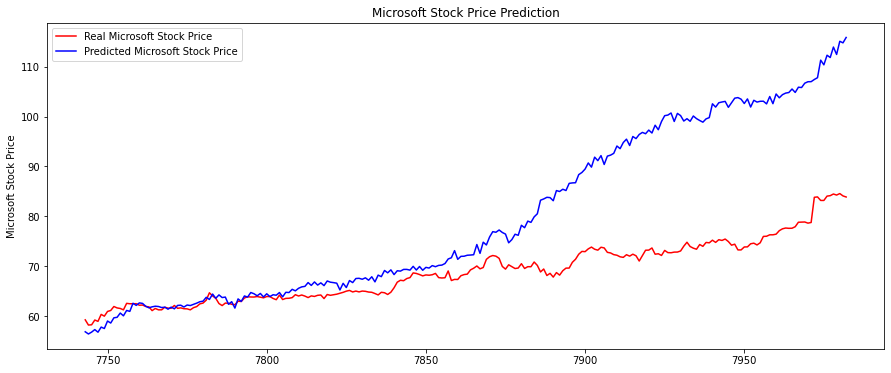

In [ ]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.plot(df[-240:].index, y_test[-240:], color = 'red', label = 'Real Microsoft Stock Price')
axes.plot(df[-240:].index, df3['pred'][-240:], color = 'blue', label = 'Predicted Microsoft Stock Price')
plt.title('Microsoft Stock Price Prediction')
plt.xlabel('')
plt.ylabel('Microsoft Stock Price')
plt.legend()
plt.savefig('Microsoft_pred_3.png')
plt.show()

>### Вывод: Прогноз цены на основе предобработанных данных демонстрирует сопоставимые метрики качества. При этом, динамика цены акции, восстановленная из прогноза процентных отклонений сильнее отклоняется от фактической цены, чем прогноз цены акции на основе "сырых" данных. Это обстоятельство хорошо визуально заметно на графиках.  Попытка увеличения количество эпох тренировки не привела к улучшению ситуации. Видимо требуется больший размер данных для обучения и/или применение кросс-валидационных методов.